In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import e, k, h
from scipy.interpolate import interp1d

ROK_ENERGY_UNIT = 1e-3*e
DELTA = 0.166*1e-3*e
V_RANGE = 0.605
FREQUENCY = 2*np.pi*368*1e6

PARAMETER_PATH = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\parameter.csv"
EXPERIMENTAL_PATH = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\Experimental data\\data-oct4-21-mail-filip\\data\\"
NRG_PATH = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\f1web.ijs.si\\~zitko\\data\\chi\\"

<IPython.core.display.Javascript object>

In [2]:
def gammaf(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator

def etta(g0, v0, T, N):
    numerator = N*gammaf(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator

def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator

def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator

def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dne - dng) - dne)

def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*gammaf(g0, smg, T, N)
    denominator = gammaf(g0, smg, T, N)**2 + w**2
    return numerator/denominator

def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)

def conductance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*(w**2)
    denominator = gammaf(g0, smg, T, N)**2 + w**2
    return numerator/denominator

In [26]:
def nrg_data_func(u,gamma):
    file_path = f"{NRG_PATH}U={u}\\U={u}_Gamma={gamma:.5f}\\"
    np.genfromtxt(f"{file_path}n2.dat")[:400]
    nrg_data = [np.genfromtxt(f"{file_path}optical1.dat")[:400], 
                np.genfromtxt(f"{file_path}n1.dat")[:400], 
                np.genfromtxt(f"{file_path}n2.dat")[:400]]
    return nrg_data

In [41]:
def dataset_func(data_idx):
    data_idx = str(data_idx).zfill(2)
    data = np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_opening_{data_idx}.csv",
               skiprows = 1,
               delimiter = ',')[:, [0, 1, 5]]
    return data[:,0:2], data[:,0:3:2]

In [5]:
def experimental_data(data_idx,symmetrize): #filter
    c_data, r_data = dataset_func(data_idx)
    
    exp_c = c_data[:,1]
    exp_g = 1/r_data[:,1]
    exp_v = c_data[:,0]*1e3
    
    filter_bool = (exp_v < V_RANGE) * (-V_RANGE < exp_v)
    
    exp_c = exp_c[filter_bool]*1e15
    exp_g = exp_g[filter_bool]*1e8
    exp_v = exp_v[filter_bool]
    
    if symmetrize:
        exp_c = (exp_c + exp_c[::-1])/2
        exp_g = (exp_g + exp_g[::-1])/2
        
    return {'exp_v':exp_v, 'exp_c':exp_c, 'exp_g':exp_g}


In [6]:
def analytical_data(gamma, log_g0, global_parameters, v0,fit_step):
    u, alpha, temp, log_n = global_parameters
    
    v0 = v0*alpha
    nu = (1 - v0/u)
    n = 10**log_n
    g0 = 10**log_g0
    if log_g0 == 0.0: g0 = 0.0
    w = FREQUENCY
    
    o1, n1, n2 = nrg_data_func(u,gamma)
    
    mini_gap = np.interp(nu, o1[:,0], o1[:, 1])*DELTA
    n_gs  = np.interp(nu, n1[:,0], n1[:, 1])
    n_es  = np.interp(nu, n2[:,0], n2[:, 1])
    dn_gs = np.interp(nu, n1[1:,0], (n1[1:, 1] - n1[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    dn_es = np.interp(nu, n2[1:,0], (n2[1:, 1] - n2[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    dn_gs = (dn_gs + dn_gs[::-1])/2
    dn_es = (dn_es + dn_es[::-1])/2
    d_mini_gap = np.interp(nu, o1[1:, 0], (o1[1:, 1] - o1[:-1, 1]) / (-0.01*u)) * DELTA / ROK_ENERGY_UNIT
    
#     gamma_v = gammaf(g0, nu, temp, n)
#     etta_v = etta(g0, nu, temp, n)
#     llambda_v = llambda(nu, temp, n)
    p0_v = p0(mini_gap, temp, n)

    q_cap_gs = alpha*alpha*q_capacitance(mini_gap, temp, n, 0, dn_gs)*1e15
    q_cap_es = alpha*alpha*q_capacitance(mini_gap, temp, n, dn_es, 0)*1e15
    q_cap = alpha*alpha*q_capacitance(mini_gap, temp, n, dn_es, dn_gs)*1e15
    t_cap = alpha*alpha*tunnel_capacitance(g0, mini_gap, d_mini_gap, temp, n, n_es, n_gs, w)*1e15
    t_cap = (t_cap + t_cap[::-1])/2
    total_cap = q_cap + t_cap
    
    conduc = alpha*alpha*conductance(g0, mini_gap, d_mini_gap, temp, n, n_es, n_gs, w)*1e8
    conduc = (conduc + conduc[::-1])/2
    
    return_set = {'mini_gap':mini_gap/DELTA,
                  'n_gs':n_gs,
                  'n_es':n_es,
                  'dn_gs':dn_gs*ROK_ENERGY_UNIT,
                  'dn_es':dn_es*ROK_ENERGY_UNIT,
                  'd_mini_gap':d_mini_gap,
#                   'gamma':gamma_v,
#                   'etta':etta_v,
#                   'lambda':llambda_v,
                  'p0':p0_v,
                  'q_cap_gs':q_cap_gs,
                  'q_cap_es':q_cap_es,
                  'q_cap':q_cap,
                  't_cap':t_cap,
                  'total_cap':total_cap,
                  'conductance':conduc}
    return return_set


In [7]:
PARAMETERS = np.loadtxt(PARAMETER_PATH, skiprows = 1, delimiter = ',')
EXPERIMENTAL_BOOL = True
LEGEND = True
X_LABEL = True
Y_LABEL = True
X_COMMON = True
Y_COMMON = False
SAVE = True
FORMAT = 'pdf' # 'svg','png'

In [8]:
CHOOSE_DATA_SETS = (0,1,2,3,4,5,6,7,8,9,10)
CHOOSE_QUANTITIES =('mini_gap',       
                    'n_gs',        
                    'n_es',          
                    'dn_gs',            
                    'dn_es',              
                    'd_mini_gap',              
                    'p0',           
                    'q_cap_gs',         
                    'q_cap_es',             
                    'q_cap',             
                    't_cap',            
                    'total_cap',           
                    'conductance')

In [9]:
LABEL_DICT = {'mini_gap':r'Shiba mini-gap, $\delta / \Delta $',
              'n_gs':r'Occupation, $n_G$',
              'n_es':r'Occupation, $n_E$',
              'dn_gs':r'Chi, $\frac{d n_G}{d \epsilon}$',
              'dn_es':r'Chi, $\frac{d n_E}{d \epsilon}$',
              'd_mini_gap':r'$\frac{d \delta}{d \epsilon}$',
              'p0':r'Steady state probability, $P_{g,0}$',
              'q_cap_gs':'GS Capacitance, $C_{Q,GS} (fF)$',
              'q_cap_es':'ES Capacitance, $C_{Q,ES} (fF)$',
              'q_cap':'Quantum Capacitance, $C_{Q} (fF)$',
              't_cap':'Tunneling Capacitance, $C_{T} (fF)$',
              'total_cap':'Capacitance, $C (fF)$',
              'conductance':'Conductance, S ($10^{-8} \Omega^{-1}$)'}

In [10]:
LOCAL_PARAMETERS = PARAMETERS[np.array(CHOOSE_DATA_SETS)][:,np.array([1,2])]
GLOBAL_PARAMETERS = PARAMETERS[0,np.array([-4,-3,-2,-1])]

In [11]:
def on_demand_plot(parameters,data_sets,quantities,save,form):
    plt.close()
    sym = 0
    local_parameters = parameters[np.array(data_sets)][:,np.array([1,2])]
    global_parameters = parameters[0,np.array([-4,-3,-2,-1])]

    scale = 5
    collumns = len(data_sets)
    rows = len(quantities)
    fig, axes = plt.subplots(rows, collumns, figsize=(collumns*scale,rows*scale),sharex=X_COMMON, sharey=Y_COMMON)
    axes = axes.transpose()
    counter = 0

    for ((log_g0,gammat), dset,axis) in zip(local_parameters,data_sets,axes):

        e_data = experimental_data(dset, sym)
        exp_v = e_data['exp_v']
        a_data = analytical_data(gammat, log_g0, global_parameters, exp_v, fit_step = 2)
        axis[0].text(0.23,1.1,
                     f'data set = {dset}\n$log_{{10}}(\\Gamma^0/Hz)={log_g0:.3f}$\n$\Gamma_t = ${gammat}',
                     transform=axis[0].transAxes,
                     fontsize=15
                    )
        for ax, quantity in zip(axis,quantities):
            
            ax.plot(exp_v, a_data[quantity],label=quantity)
            
            if (quantity in ('q_cap_gs','q_cap_es','q_cap','t_cap','total_cap') and EXPERIMENTAL_BOOL):
                ax.plot(exp_v, e_data['exp_c'])
            if (quantity=='conductance' and EXPERIMENTAL_BOOL):
                ax.plot(exp_v, e_data['exp_g'])
            if (not counter) and Y_LABEL:
                ax.set_ylabel(LABEL_DICT[quantity],fontsize=15)
                counter = 0
                    
            if LEGEND: ax.legend()
        counter += 1

    if X_LABEL: axes[int(collumns/2)][-1].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
    u, alpha, temp, log_n = global_parameters
    parameter_string = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} meV $\
            $log_{{10}} N   = {log_n:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    
    if save:
        plt.savefig(f"plots_sym_ALL_ALL.{form}", format=form)
#         plt.savefig(f"plots_sym_{[f'{member}' for member in data_sets]}_{[f'{member}' for member in quantities]}.{form}", format=form)

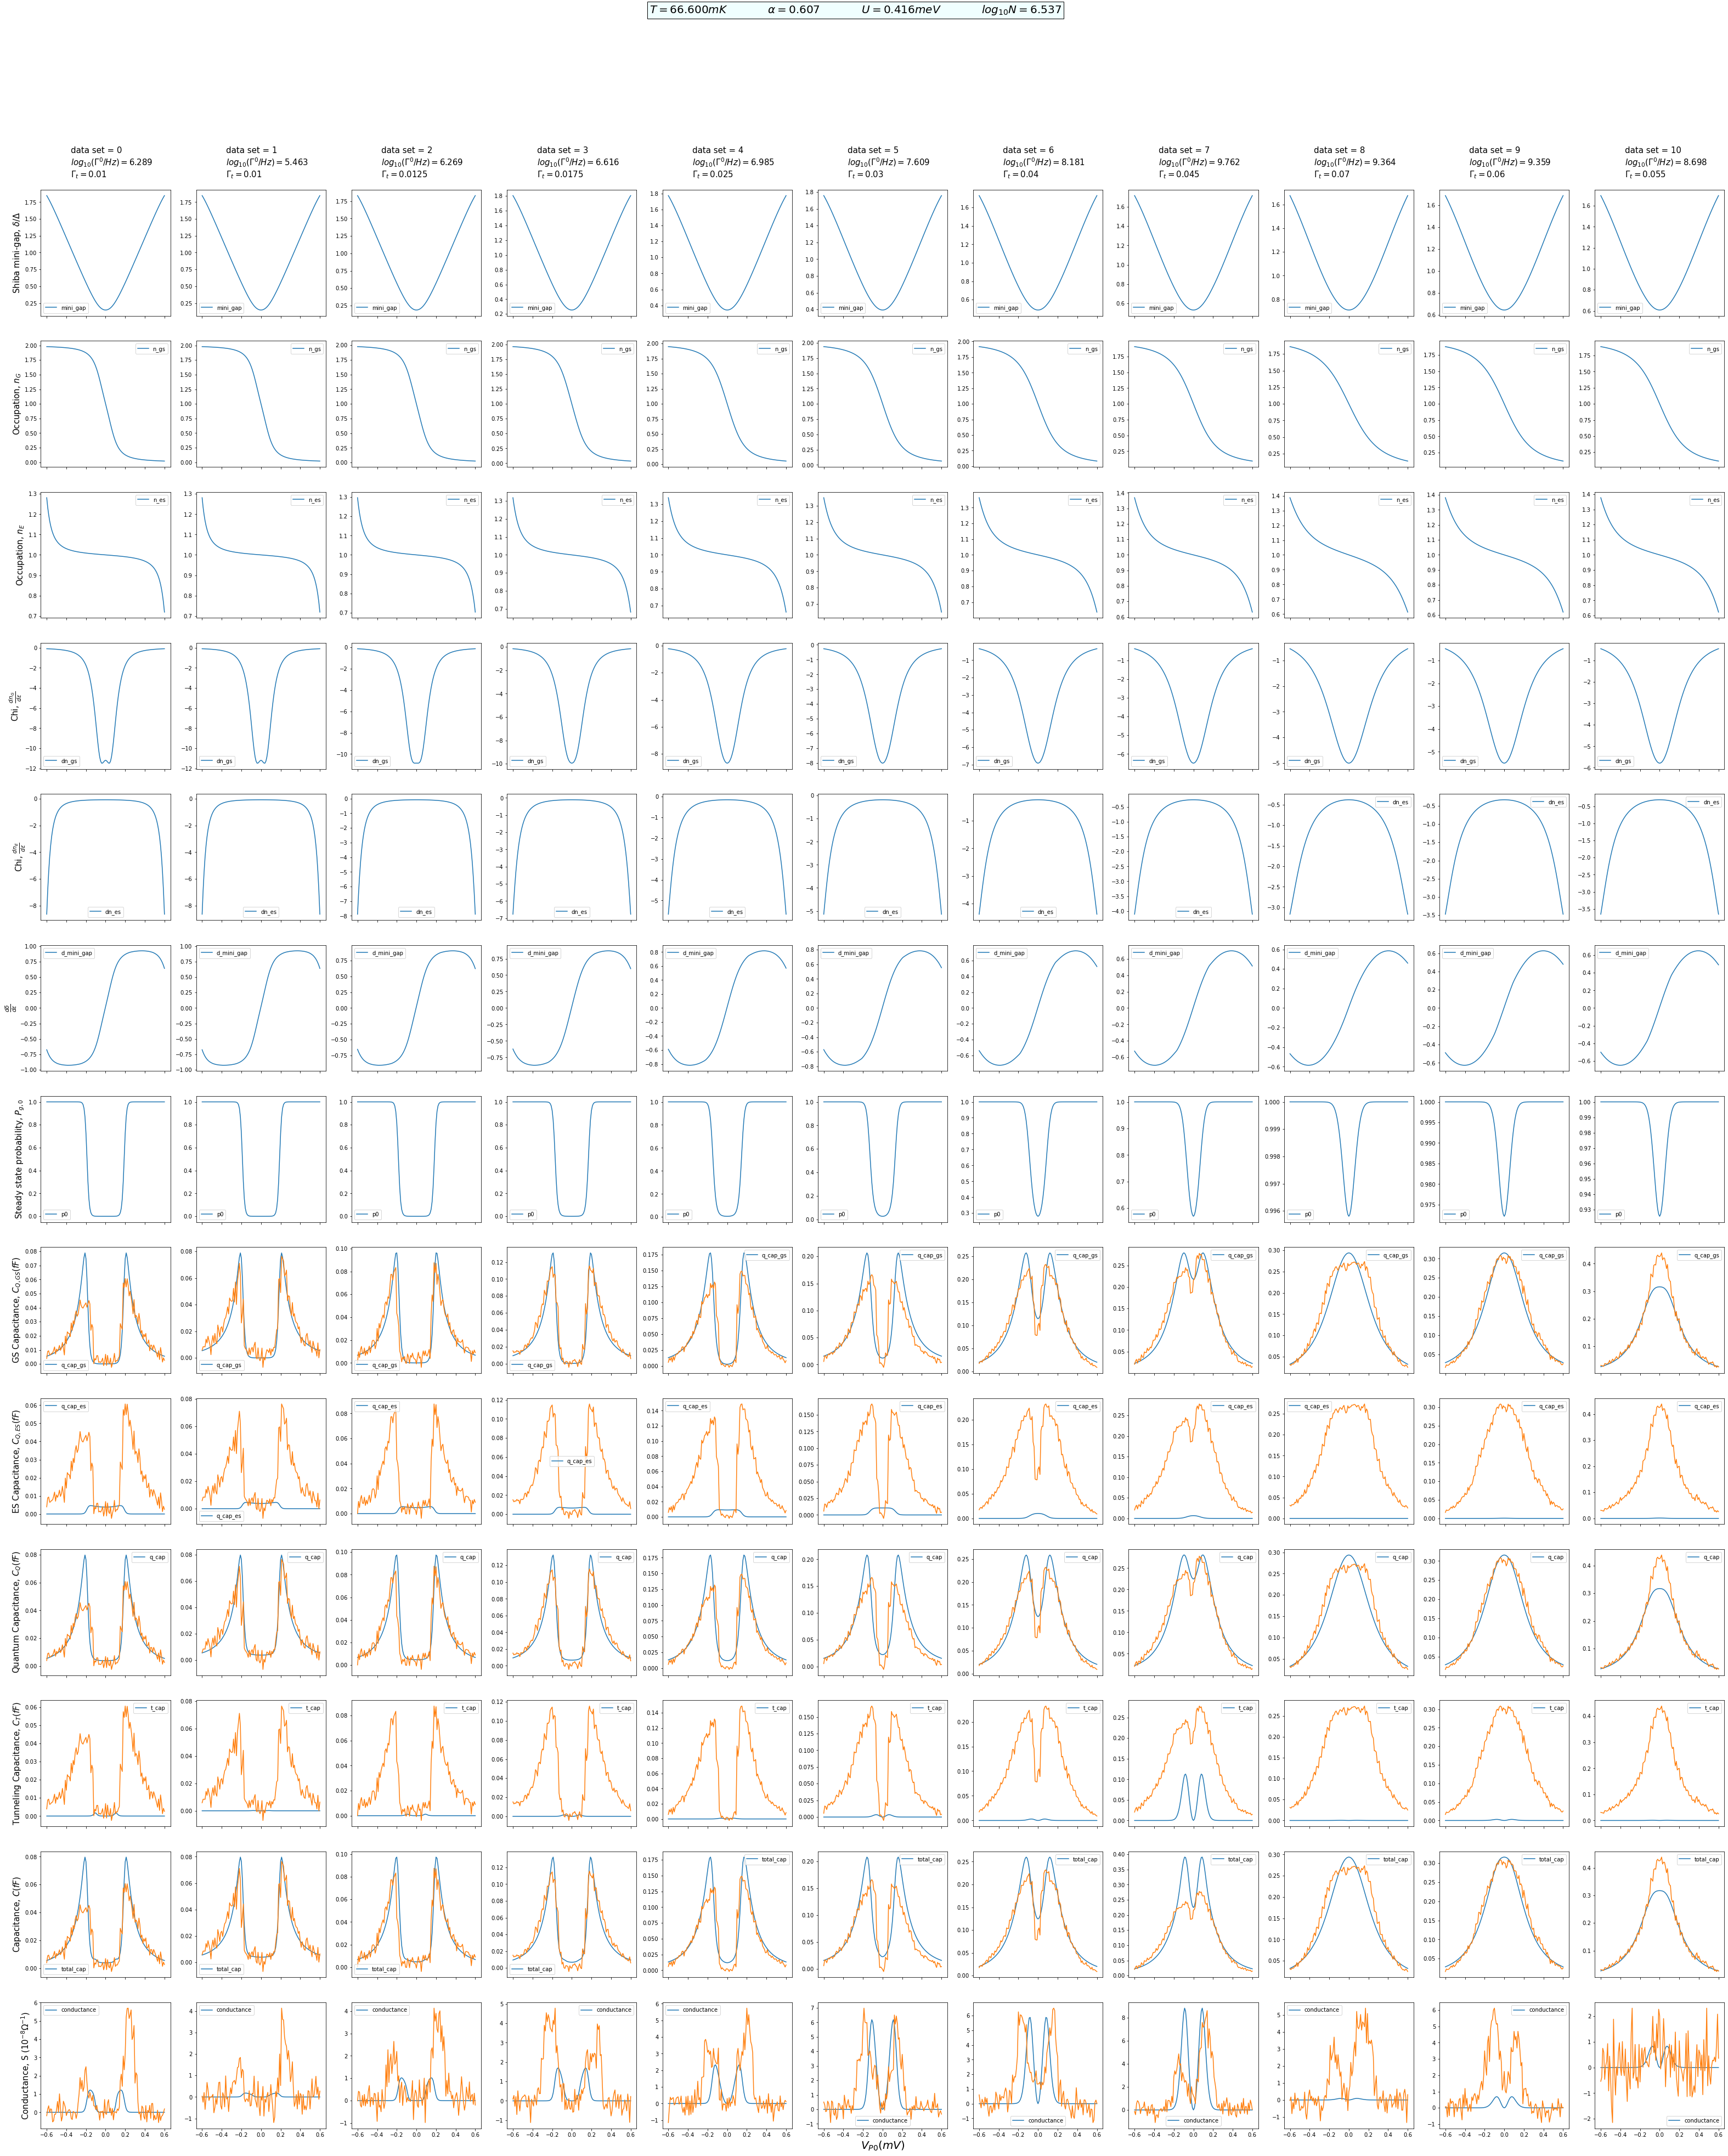

In [12]:
on_demand_plot(PARAMETERS,CHOOSE_DATA_SETS,CHOOSE_QUANTITIES,SAVE,FORMAT)

In [13]:
time_end = time.time()
print(round(-time_strt + time_end, 3))

51.644
